# Deep Reinforcement Learning: Policy Gradient

Taken from https://medium.com/@ts1829/policy-gradient-reinforcement-learning-in-pytorch-df1383ea0baf

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')

In [3]:
#Hyperparameters
LEARNING_RATE = 0.01
GAMMA = 0.99

In [4]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        self.l1 = nn.Linear(self.state_space, 128, bias=False)
        self.l2 = nn.Linear(128, self.action_space, bias=False)
        
        self.gamma = GAMMA
        
        # Episode policy and reward history 
        self.policy_history = torch.Tensor()
        self.reward_episode = []
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []

    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.6),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)

In [5]:
policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=LEARNING_RATE)

In [6]:
def select_action(state, is_eval=0):
    #Select an action (0 or 1) by running policy model and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    state = policy(state)
    c = Categorical(state)
    action = c.sample()
    
    if not is_eval:
        # Add log probability of our chosen action to our history    
        if len(policy.policy_history.size()) != 0:
            policy.policy_history = torch.cat([policy.policy_history, c.log_prob(action).unsqueeze(0)])
        else:
            policy.policy_history = torch.Tensor(c.log_prob(action))
    return action

In [7]:
def update_policy():
    R = 0
    rewards = []
    
    # Discount future rewards back to the present using gamma
    for r in policy.reward_episode[::-1]:
        R = r + policy.gamma * R
        rewards.insert(0,R)
        
    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    
    # Calculate loss
    loss = (torch.sum(torch.mul(policy.policy_history, rewards).mul(-1), -1))
    
    # Update network weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    policy.loss_history.append(loss.item())
    policy.reward_history.append(np.sum(policy.reward_episode))
    policy.policy_history = torch.Tensor()
    policy.reward_episode= []

In [8]:
def evaluate():
    state = env.reset()
    for t in range(2000):
        env.render()
        action = select_action(state, 1)
        state, reward, done, info = env.step(action.item())
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()

In [9]:
evaluate()

Episode finished after 12 timesteps


In [10]:
def main(episodes):
    running_reward = 10
    for episode in range(episodes):
        state = env.reset() # Reset environment and record the starting state
        done = False       
    
        for time in range(1000):
            action = select_action(state)
            # Step through environment using chosen action
            state, reward, done, _ = env.step(action.item())

            # Save reward
            policy.reward_episode.append(reward)
            if done:
                break
        
        # Used to determine when the environment is solved.
        running_reward = (running_reward * 0.99) + (time * 0.01)

        update_policy()

        if episode % 50 == 0:
            print('Episode {}\tLast length: {:5d}\tAverage length: {:.2f}'.format(episode, time, running_reward))

        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and the last episode runs to {} time steps!".format(running_reward, time))
            break

In [11]:
episodes = 1000
main(episodes)

Episode 0	Last length:    35	Average length: 10.25
Episode 50	Last length:   167	Average length: 27.51
Episode 100	Last length:   426	Average length: 96.72
Episode 150	Last length:   236	Average length: 206.53
Episode 200	Last length:   499	Average length: 260.33
Episode 250	Last length:   499	Average length: 340.78
Episode 300	Last length:   499	Average length: 400.99
Episode 350	Last length:   499	Average length: 433.73
Episode 400	Last length:   499	Average length: 457.13
Episode 450	Last length:   499	Average length: 472.62
Solved! Running reward is now 475.14306637528415 and the last episode runs to 499 time steps!


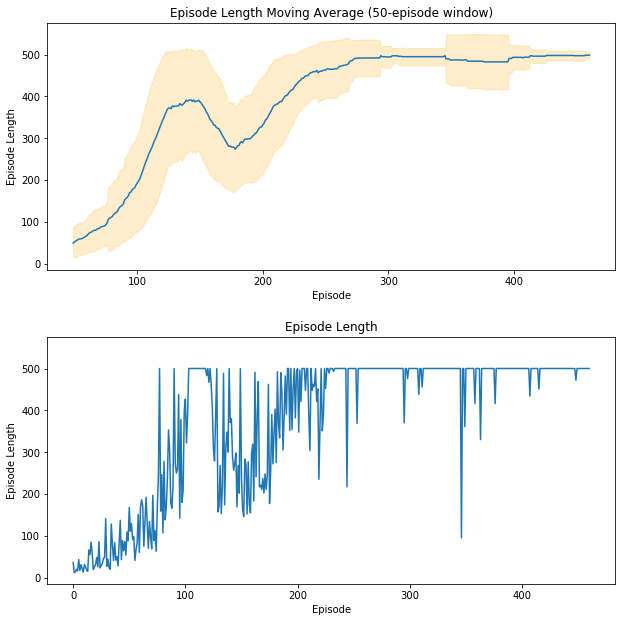

In [12]:
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(policy.reward_history).rolling(window).mean()
std = pd.Series(policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Episode Length Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Length')

ax2.plot(policy.reward_history)
ax2.set_title('Episode Length')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Length')

fig.tight_layout(pad=2)
plt.show()

In [13]:
evaluate()

Episode finished after 500 timesteps
